In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import pdb
import glob
import itertools
import numpy.ma as ma

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [348]:
VERA_data_dir = '/home/ck/DIR/cornkle/data/vera_test/vera_run_data/'


lon_uv = VERA_data_dir+'VERA_4km/longitude_uv.nc'
lat_uv = VERA_data_dir+'VERA_4km/latitude_uv.nc'
lon_t = VERA_data_dir+'VERA_4km/longitude_t.nc'
lat_t = VERA_data_dir+'VERA_4km/latitude_t.nc'
flux = VERA_data_dir+'VERA_lhsh/'
wind = VERA_data_dir+'VERA_uv/'

In [349]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines(resolution='50m')   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()  

In [160]:
lh = xr.open_mfdataset(flux+'*LH*.nc')

In [161]:
u = xr.open_mfdataset(wind+'*U10m*.nc')

In [162]:
lon_t_da = xr.open_dataarray(lon_t)
lat_t_da = xr.open_dataarray(lat_t)
lon_uv_da = xr.open_dataarray(lon_uv)
lat_uv_da = xr.open_dataarray(lat_uv)

In [329]:
lh_mean = lh['STASH_m01s03i234'].mean('time')

In [330]:
u_mean = u['STASH_m01s03i225'].mean('time')

In [331]:
u_mean

<xarray.DataArray 'STASH_m01s03i225' (lat: 700, lon: 1128)>
dask.array<shape=(700, 1128), dtype=float32, chunksize=(700, 1128)>
Coordinates:
  * lon      (lon) float32 340.018 340.054 340.09 ... 380.518 380.554 380.59
  * lat      (lat) float32 -8.982 -8.946 -8.91 -8.874 ... 16.11 16.146 16.182

In [332]:
lh_mean

<xarray.DataArray 'STASH_m01s03i234' (lat: 701, lon: 1128)>
dask.array<shape=(701, 1128), dtype=float32, chunksize=(701, 1128)>
Coordinates:
  * lon      (lon) float32 340.0 340.036 340.072 ... 380.5 380.536 380.572
  * lat      (lat) float32 -9.0 -8.964 -8.928 -8.892 ... 16.128 16.164 16.2

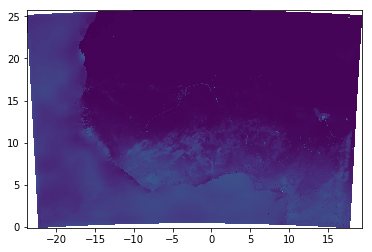

In [333]:
plt.pcolormesh(lon_t_da, lat_t_da, lh_mean)

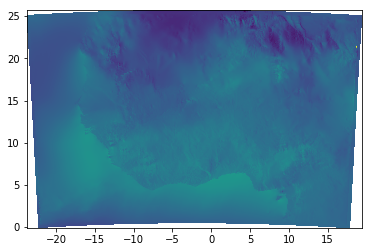

In [334]:
plt.pcolormesh(lon_uv_da, lat_uv_da, u_mean)

In [401]:
#### select point or small box, not great for plotting:
sel_box = ((lon_t_da>-5) & (lon_t_da<0) & (lat_t_da>4.5) & (lat_t_da<5.5))

In [336]:
#pick box for entire timeseries: repeat box mask
#lh_box = lh_mean.where(np.repeat(sel_box.values[np.newaxis, :,:], len(lh_mean.time),axis=0), drop=True)

In [341]:
lh_box = lh_mean.where(sel_box, drop=False)

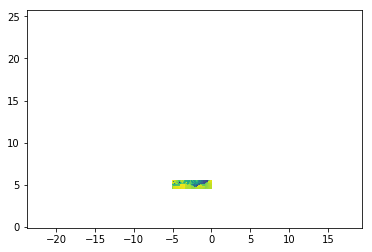

In [343]:
#### The domain is filled with NaN except for the selected area. You can use that for averaging etc 
plt.pcolormesh(lon_t_da, lat_t_da, lh_box)

In [345]:
## To get rid of those NaNs:
lh_box_drop = lh_mean.where(sel_box, drop=True)
lat_box_drop = lat_t_da.where(sel_box, drop=True)
lon_box_drop = lon_t_da.where(sel_box, drop=True)

In [346]:
xlim = np.linspace(np.nanmin(lon_box_drop), np.nanmax(lon_box_drop), lh_box_drop.shape[1])
ylim = np.linspace(np.nanmin(lat_box_drop), np.nanmax(lat_box_drop), lh_box_drop.shape[0])

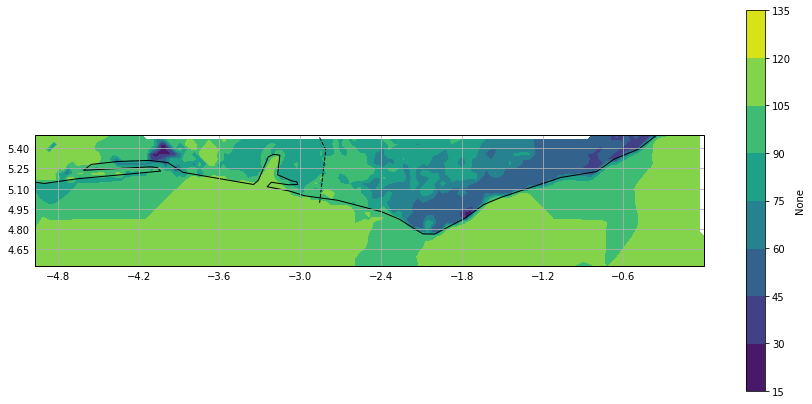

In [351]:
draw_map(lh_box_drop, xlim,ylim)

In [354]:
def unstagger_wind(var):

    if var.ndim == 1:
        unstag_ndim = var[0:-1] + (var[1::] - var[0:-1]) / 2

    if var.ndim == 2:
        unstag = var#[:, 0:-1]  + (var[:, 1::] - var[:, 0:-1]) / 2 # xdir
        unstag_ndim = unstag[0:-1, :]  + (unstag[1::, :] - unstag[0:-1, :]) / 2 # ydir

    if var.ndim == 3:
        unstag = var#[:, :, 0:-1]  + (var[:, :, 1::] - var[:, :, 0:-1]) / 2 # xdir
        unstag_ndim = unstag[:, 0:-1, :]  + (unstag[:, 1::, :] - unstag[:, 0:-1, :]) / 2 # ydir

    if var.ndim == 4:
        unstag = var#[:, :, :, 0:-1]  + (var[:, :, :, 1::] - var[:, :, :, 0:-1]) / 2 # xdir
        unstag_ndim = unstag[:, :, 0:-1, :]  + (unstag[:, :, 1::, :] - unstag[:, :, 0:-1, :]) / 2 # ydir

    return unstag_ndim

In [355]:
unstag_u = unstagger_wind(lh_mean.values)

In [356]:
unstag_u.shape

(700, 1128)

In [375]:
unstag = u_mean.copy('deep')
unstag.name = 'LH'

In [376]:
unstag.values = unstag_u

In [377]:
#### select point or small box, not great for plotting:
sel_box_uv = ((lon_uv_da>-5) & (lon_uv_da<0) & (lat_uv_da>4.5) & (lat_uv_da<5.5))

In [389]:
ubox = unstag.where(sel_box_uv, drop=False)

In [403]:
lhstag = lh_mean.where(sel_box, drop=False)

In [404]:
lhstag

<xarray.DataArray (lat: 701, lon: 1128)>
dask.array<shape=(701, 1128), dtype=float32, chunksize=(701, 1128)>
Coordinates:
  * lon      (lon) float32 340.0 340.036 340.072 ... 380.5 380.536 380.572
  * lat      (lat) float32 -9.0 -8.964 -8.928 -8.892 ... 16.128 16.164 16.2

In [391]:
umean_box = u_mean.where(sel_box_uv,drop=False)

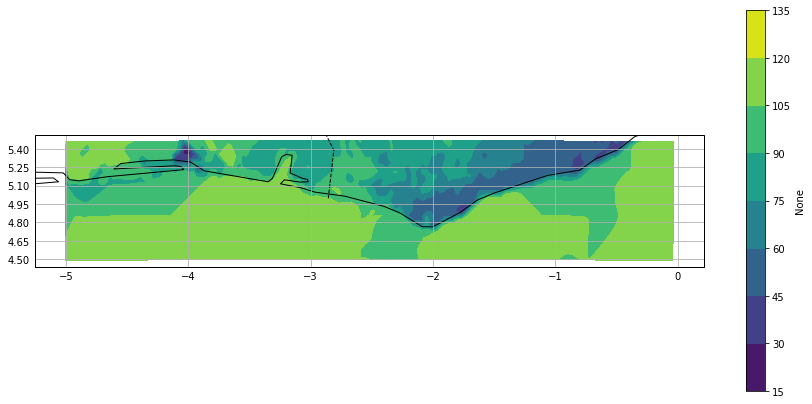

In [396]:
draw_map(ubox, lon_t_da[0:-1,:], lat_t_da[0:-1,:])

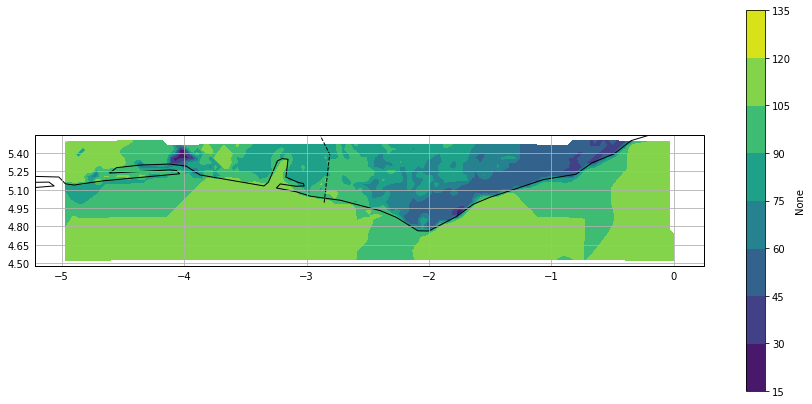

In [405]:
draw_map(lhstag, lon_t_da, lat_t_da)

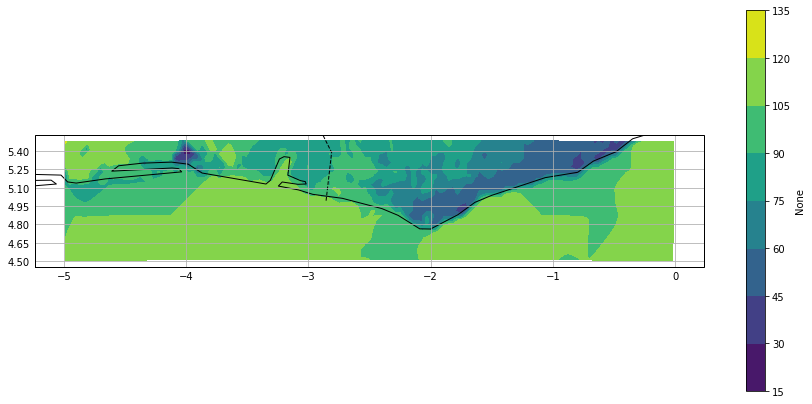

In [393]:
draw_map(ubox, lon_uv_da, lat_uv_da)

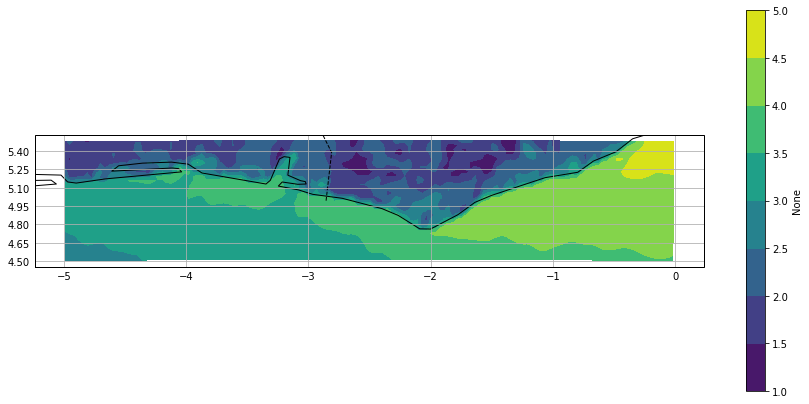

In [394]:
draw_map(umean_box, lon_uv_da, lat_uv_da)